In [59]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
import numpy.random as rnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import KFold
from itertools import product
from collections import Counter
import itertools
import inspect
from sklearn.linear_model import LinearRegression
from IPython.display import display, clear_output

In [30]:
arr = np.genfromtxt('data/prices.csv', delimiter=',')
xs, ys = arr[:,:2].copy()[1:], arr[:, 2:].ravel()[1:]
print("Dataset size: ", len(xs))

Dataset size:  47


<IPython.core.display.Javascript object>


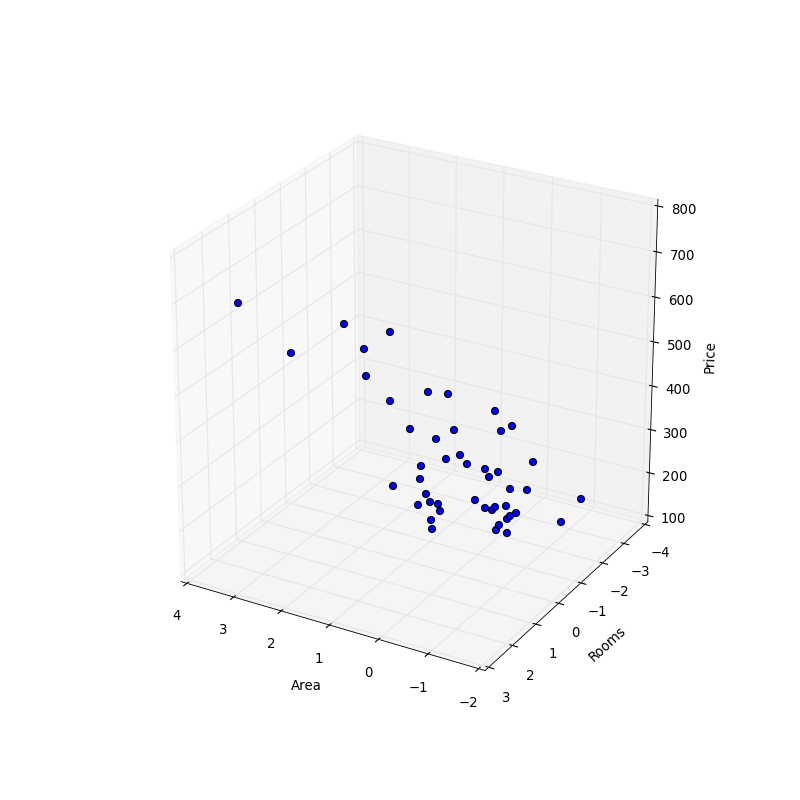

In [49]:
def show(xs, ys, elev=25.0, azim=120):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter(xs[:, 0], xs[:, 1], ys, s=40, zdir='z', depthshade=False)
    
    ax.set_xlabel('Area')
    ax.set_ylabel('Rooms')
    ax.set_zlabel('Price')
    
    ax.view_init(elev=elev, azim=azim)
    #‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
    
    plt.show()
x_scaled = StandardScaler().fit_transform(xs)
y_scaled = ys/1000
show(x_scaled, y_scaled)

<IPython.core.display.Javascript object>


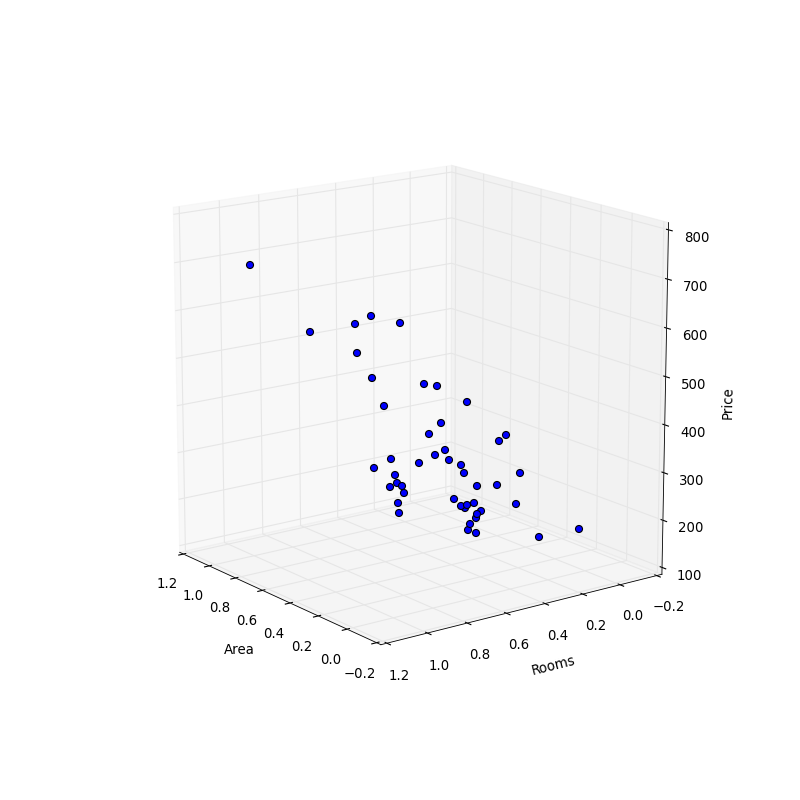

In [50]:
show(MinMaxScaler().fit_transform(xs), y_scaled)

In [51]:
def kf_cross_validation(regressor, xs, ys, n_fold=10, times=1, **params):
    measure = lambda x, y: ((x-y)**2).mean()
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True, 0)
        kf_sum = 0
        fold_num = 0
        for train_i, test_i in kf:
            regressor = regressor.fit(xs[train_i], ys[train_i], **params)
            predicted = np.apply_along_axis(regressor.predict, 1, xs[test_i])
            meas = measure(predicted, ys[test_i])
            fold_num += 1
            kf_sum += meas
            print("Time {}, fold {} done, error = {}".format(_, fold_num, meas))
        res += kf_sum/n_fold
    clear_output()
    return res/times

In [52]:
class LinearRegressor:
    def __init__(self, dim, kernel=None, scaler=None):
        if kernel is None:
            kernel = lambda x: np.hstack((1,x))
        self.scaler = scaler
        self.kernel = kernel
        self.dim = dim
        t = kernel(np.random.uniform(0, 1, dim))
        if t[0] != 1:
            print('Warning: kernel(np.random.uniform(0, 1, dim))[0] != 1')
        self.w = np.zeros(len(t))
    
    def _sgd(self, X, Y, reg=1., lr=0.1, eps=1e-9, maxiter=1000):
        self.w = np.zeros(X.shape[1])
        m = len(X)
        last_obj= -np.inf
        t = lr
        lr = 1.
        for it in range(maxiter):
            for x, y in zip(X, Y):
                self.w = (1 - lr*reg/m) * self.w - lr * (np.inner(self.w, x) - y) * x / m
            cur_obj = ((np.dot(X, self.w) - Y)**2).mean()/2 + (self.w**2).sum() * reg/(2*m)
            if abs(last_obj - cur_obj) < eps:
                break
            last_obj = cur_obj
            lr = lr*(1+lr*t*it)**-1
        return self.w
    
    def _analytics(self, X, Y, reg=1.):
        tmp = np.dot(X.transpose(), X)
        tmp += np.eye(tmp.shape[0]) * reg     
        tmp = np.linalg.inv(tmp)
        self.w = np.dot(Y, np.dot(X, tmp))
        return self.w
    
    def fit(self, X, y, reg=1., solver='sgd', **params):
        if self.scaler is not None:
            self.scaler = self.scaler.fit(X)
            X = self.scaler.transform(X)
        X = np.apply_along_axis(self.kernel, 1, X)
        if solver == 'sgd':
            self._sgd(X, y, reg, **params)  
        elif solver == 'analytics':
            self._analytics(X, y, reg, **params)
        return self
        
    def predict(self, x):
        if self.scaler is not None:
            x = self.scaler.transform(x.reshape(1, -1)).ravel()
        x = self.kernel(x)
        return np.inner(self.w, x)

In [53]:
regressor = LinearRegressor(2, scaler=StandardScaler())
print(kf_cross_validation(regressor, xs, ys, n_fold=7, times=1, solver='sgd', lr=0.0001, reg=0))

4755493983.62


In [54]:
print(kf_cross_validation(regressor, xs, ys, n_fold=7, times=1, solver='analytics', reg=0))

4753869366.15


In [55]:
import numpy as np
from Misc import gen_random_combination

class GeneticOptimization:

    def __crossover(self, x, y):
        indices = np.arange(1, self.dim).reshape(self.dim - 1, 1)
        return np.apply_along_axis(lambda s: np.append(x[:s], y[s:]), 1, indices).ravel()

    def __multi_crossover(self, x, xs):
        return np.apply_along_axis(lambda y: self.__crossover(x, y), 1, xs).ravel()

    def __to_bounds(self, val):
        return val * (self.max_value - self.min_value) + self.min_value

    def __mutation(self, x):
        x[rnd.randint(0, self.dim - 1)] = self.__to_bounds(rnd.rand())
        return x

    def __metric(self, predicted, label):
        return ((predicted - label) ** 2).mean()

    def fit(self, xs, ys, pop_size=50, iters=50,
            error=0.001, mutation_part=0.2, reproduction_part=0.2, min_value=0, max_value=1.,
            verbose=False):

        minimize_f = lambda w: self.__metric(np.apply_along_axis(lambda x: np.dot(w, x), 1, xs), ys)
        dim = len(xs[0])
        self.dim = dim
        self.max_value = max_value
        self.min_value = min_value
        population = self.__to_bounds(rnd.random([pop_size, dim]))

        for it in range(iters):
            cur_population_size = len(population)
            seq_indexes = np.arange(0, cur_population_size).reshape(cur_population_size, 1)

            parents_ids = np.apply_along_axis(
                lambda ind: gen_random_combination(cur_population_size, int(reproduction_part * cur_population_size), ind), 1,
                seq_indexes)

            new_population = np.apply_along_axis(
                lambda ind: self.__multi_crossover(population[ind[0]], population[parents_ids[ind[0]]]), 1,
                seq_indexes).reshape((-1, dim))

            mutation_population = np.apply_along_axis(
                lambda x: self.__mutation(x) if rnd.rand() < mutation_part else x, 1,
                new_population)

            fitness = np.apply_along_axis(minimize_f, 1, mutation_population)

            best_indices = np.argsort(fitness)[:pop_size]
            min_error = fitness[best_indices[0]]
            population = new_population[best_indices]
            if min_error < error:
                if verbose:
                    print("Optimization complete, requirement error reached {}", min_error)
                self.w = population[0]
                return self
            if verbose:
                print("Iteration {} done. Current error {}".format(it + 1, min_error))
        if verbose:
            print("Optimization completed, requirement number of iterations reached")
        self.w = population[0]
        return self

    def predict(self, x):
        return np.dot(self.w, x)

    def weights(self):
        return self.w

In [56]:
def append_one(xs):
    return np.apply_along_axis(lambda x: np.append(x, 1), 1, xs)
def transform1(xs):
    return np.apply_along_axis(lambda x: [x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]], 1, xs)
def transform2(xs):
    return np.apply_along_axis(lambda x: [x[0], x[1], x[0]*x[1]], 1, xs)
ga = GeneticOptimization()

In [60]:
kf_cross_validation(ga, StandardScaler().fit_transform(xs), ys, n_fold=7, iters=10, max_value=1e6)

126792415365.49014

In [39]:
xs_scaled = MinMaxScaler().fit_transform(xs)
xs_transformed1=append_one(xs_scaled)
kf_cross_validation(ga, xs_transformed1, ys, n_fold=7, iters=10, max_value=1e6)

5106310332.4407558

In [40]:
kf_cross_validation(ga, xs_transformed1, ys, n_fold=7, iters=10, reproduction_part=0.7, mutation_part=0.5, max_value=1e6)

4596376636.6673489

In [45]:
xs_transformed2=append_one(transform2(xs_scaled))
kf_cross_validation(ga, xs_transformed2, ys, n_fold=7, iters=10, max_value=1e6)

4924255298.5260324

In [47]:
xs_transformed2=append_one(transform1(xs_scaled))
kf_cross_validation(ga, xs_transformed2, ys, n_fold=7, iters=10, reproduction_part=0.5, mutation_part=0.7, max_value=1e6)

5027043449.233881